In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.26.4
!pip install -U -q tensorflow tensorflow_datasets tf2onnx==1.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-decision-forests 1.

In [3]:
#unzip the data

import pathlib
import tensorflow as tf
import os
import zipfile

# Path to your ZIP file on Google Drive
ZIP_FILE_PATH_DRIVE = '/content/drive/MyDrive/ble_p/dataset/all_comand.zip' # ADJUST THIS PATH if needed

# Directory where you want to extract the dataset in Colab's temporary storage
EXTRACTED_DATASET_PATH = '/content/korean_speech_commands' # You can name this whatever you like

data_dir = pathlib.Path(EXTRACTED_DATASET_PATH)

if not data_dir.exists():
    print(f"Extracting {ZIP_FILE_PATH_DRIVE} to {EXTRACTED_DATASET_PATH}...")
    # Create the target directory if it doesn't exist
    os.makedirs(EXTRACTED_DATASET_PATH, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(ZIP_FILE_PATH_DRIVE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_DATASET_PATH)
    print("Extraction complete.")
else:
    print(f"Dataset already exists at {EXTRACTED_DATASET_PATH}.")

# Verify the contents (optional, but good for checking)
# List the subdirectories (which should be your command class names)
if data_dir.exists():
     extracted_commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
     print(f"Found {len(extracted_commands)} command folders: {extracted_commands[:5]}...") # Print first 5
else:
    print(f"Error: data_dir {data_dir} does not exist after attempted extraction.")

Extracting /content/drive/MyDrive/ble_p/dataset/all_comand.zip to /content/korean_speech_commands...
Extraction complete.
Found 1 command folders: ['all_comand']...


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
import torch
import torch.nn as nn
import torchaudio

class SpeechModel(nn.Module):
    def __init__(self, num_classes=32):
        super(SpeechModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 42 * 140, 128)  # Adjusted for [171, 560] after pooling
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Example usage
model = SpeechModel(num_classes=32)
model.eval()

# Preprocess audio (simplified)
def get_spectrogram_pytorch(waveform, sample_rate=16000):
    transform = torchaudio.transforms.Spectrogram(n_fft=512, hop_length=128, power=None)
    spec = transform(waveform)
    spec = torch.abs(spec)
    spec = torch.nn.functional.interpolate(spec.unsqueeze(0).unsqueeze(0), size=(171, 560), mode='bilinear', align_corners=False)
    return spec

# Export to ONNX
dummy_input = torch.zeros(1, 1, 171, 560)  # Batch, Channel, Height, Width
torch.onnx.export(model, dummy_input, "pytorch_model.onnx", opset_version=13, input_names=['input'], output_names=['output'])

## WITH pytorch


In [ ]:
import os
import pathlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torchaudio import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Audio
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define constants
DATASET_PATH = '/content/korean_speech_commands/all_comand'  # Replace with your actual path
MAX_AUDIO_SECONDS = 4
SAMPLE_RATE = 16000
OUTPUT_SEQ_LEN = MAX_AUDIO_SECONDS * SAMPLE_RATE  # 64000 samples
NUM_CLASSES = 32  # Placeholder, will be set based on labels.txt

# Extract folder names and save to labels.txt
def save_labels_to_file(data_dir):
    data_path = pathlib.Path(data_dir)
    label_names = [d.name for d in data_path.iterdir() if d.is_dir()]
    label_names.sort()  # Ensure consistent order
    with open('labels.txt', 'w', encoding='utf-8') as f:
        f.write("Detected Label Names:\n")
        for label in label_names:
            f.write(f"Label: {label}\n")
    return label_names

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, data_dir, label_names):
        self.data_dir = pathlib.Path(data_dir)
        self.label_names = label_names
        self.data = []
        self.labels = []
        for i, label in enumerate(label_names):
            label_dir = self.data_dir / label
            for file in label_dir.glob('*.wav'):
                self.data.append(str(file))
                self.labels.append(i)
        self.label_to_idx = {label: idx for idx, label in enumerate(label_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.data[idx])
        waveform = waveform.mean(dim=0)  # Convert to mono if stereo
        waveform = torch.nn.functional.pad(waveform, (0, OUTPUT_SEQ_LEN - waveform.shape[0]))[:OUTPUT_SEQ_LEN]
        spectrogram = self.get_spectrogram(waveform)
        label = self.labels[idx]
        return spectrogram, label

    def get_spectrogram(self, waveform):
        transform = transforms.Spectrogram(n_fft=512, hop_length=128, power=None)
        spec = transform(waveform)  # Shape: [freq_bins, time_steps] e.g., [257, 501]
        spec = torch.abs(spec)  # Magnitude spectrogram
        # Add channel dimension and treat as [N, C, H, W] for interpolation
        spec = spec.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, freq_bins, time_steps]
        spec = torch.nn.functional.interpolate(spec, size=(171, 560), mode='bilinear', align_corners=False)
        return spec.squeeze(0)  # Shape: [1, 171, 560], remove the batch dimension

# Load labels from labels.txt
if os.path.exists('labels.txt'):
    with open('labels.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        label_names = [line.split(': ')[1].strip() for line in lines[1:] if ':' in line]
else:
    label_names = save_labels_to_file(DATASET_PATH)
    with open('labels.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        label_names = [line.split(': ')[1].strip() for line in lines[1:] if ':' in line]
print(f"Loaded {len(label_names)} labels: {label_names}")

# Update NUM_CLASSES based on the number of labels
NUM_CLASSES = len(label_names)

# Create dataset and split
dataset = AudioDataset(DATASET_PATH, label_names)
train_data, val_data = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_data)
val_dataset = torch.utils.data.Subset(dataset, val_data)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define the model
class SpeechModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SpeechModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 42 * 140, 128)  # Adjusted for [171, 560] after pooling
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
def train_model(model, train_loader, val_loader, epochs=1, patience=7, min_epochs=1):
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (spectrograms, labels) in enumerate(train_loader):
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for spectrograms, labels in val_loader:
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                outputs = model(spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')

        # Early stopping
        if epoch >= min_epochs - 1:  # Only apply early stopping after min_epochs
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(torch.load('best_model.pth'))
                    break
        else:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')

# Train the model
train_model(model, train_loader, val_loader, epochs=50, patience=10, min_epochs=15)

# Inference on a sample from the dataset
sample_path = os.path.join(DATASET_PATH, '드론', 'aug_clean_speaker0_Drone_3_volume.wav')  # Example file from dataset
waveform, sample_rate = torchaudio.load(sample_path)
waveform = waveform.mean(dim=0)  # Convert to mono
waveform = torch.nn.functional.pad(waveform, (0, OUTPUT_SEQ_LEN - waveform.shape[0]))[:OUTPUT_SEQ_LEN]
spectrogram = AudioDataset(DATASET_PATH, label_names).get_spectrogram(waveform).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(spectrogram.unsqueeze(0))  # Add batch dimension
    predicted_probabilities = torch.softmax(output, dim=1).cpu().numpy()
    predicted_index = torch.argmax(output).cpu().numpy()
    predicted_label = label_names[predicted_index]
    confidence = predicted_probabilities[0][predicted_index]
    true_label = '드론'  # Known true label for this file
    is_correct = predicted_index == label_names.index(true_label)

print(f"Predicted label: {predicted_label} (Confidence: {confidence:.2f})")
print(f"True label: {true_label}")
print(f"Prediction is {'correct' if is_correct else 'incorrect'}")

# Plot the prediction
plt.figure(figsize=(12, 6))
plt.bar(label_names, predicted_probabilities[0])
plt.title(f'Prediction for {os.path.basename(sample_path)}')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Play the audio
# display.display(Audio(waveform, rate=SAMPLE_RATE))

# Export to ONNX
dummy_input = torch.zeros(1, 1, 171, 560).to(device)
torch.onnx.export(model, dummy_input, "pytorch_model.onnx", opset_version=13, input_names=['input'], output_names=['output'])
print("Model exported to pytorch_model.onnx")

Loaded 50 labels: ['100미터', '10미터', '12시', '1미터', '1시', '200미터', '20미터', '2시', '300미터', '3미터', '3시', '400미터', '40미터', '5미터', '60미터', '6시', '80미터', '9시', 'IR꺼', 'IR켜', '경계', '경계모드', '공격모드', '느리게', '대기', '드론', '매우느리게', '매우빠르게', '모드변경', '복귀', '빠르게', '사격', '아래', '야간모드', '우로', '우회전', '위', '전방', '전진', '정지', '정찰', '정찰모드', '조명꺼', '조명켜', '조준', '좌로', '좌회전', '주행모드', '후방', '후진']


Using N_FFT: 512, HOP_LENGTH: 114
Number of frames from librosa before resize (approx): 557
Dataset found at /content/korean_speech_commands/only_command
Commands (detected folder names): ['IR_꺼짐', 'IR_켜짐', '경고', '경고_모드', '공격_모드', '느림', '대기', '뒤로', '뒤로 이동', '드론', '매우_느림', '매우_빠름', '모드_변경', '발사', '복귀', '빠름', '아래에', '앞으로', '앞으로_이동', '야간_모드', '오른쪽_이동', '오른쪽_회전', '왼쪽_이동', '왼쪽_회전', '운전_모드', '위(하늘)', '정지', '정찰', '정찰_모드', '조명_꺼짐', '조명_켜짐', '조준']
Found 32 classes.
Train dataset size: 1916 samples
Validation dataset size: 239 samples
Test dataset size: 240 samples
Batch spectrogram shape: torch.Size([32, 1, 171, 560])
Batch labels shape: torch.Size([32])


<ipython-input-17-395608750>:254: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 44732 (\N{HANGUL SYLLABLE GGEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-395608750>:254: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-

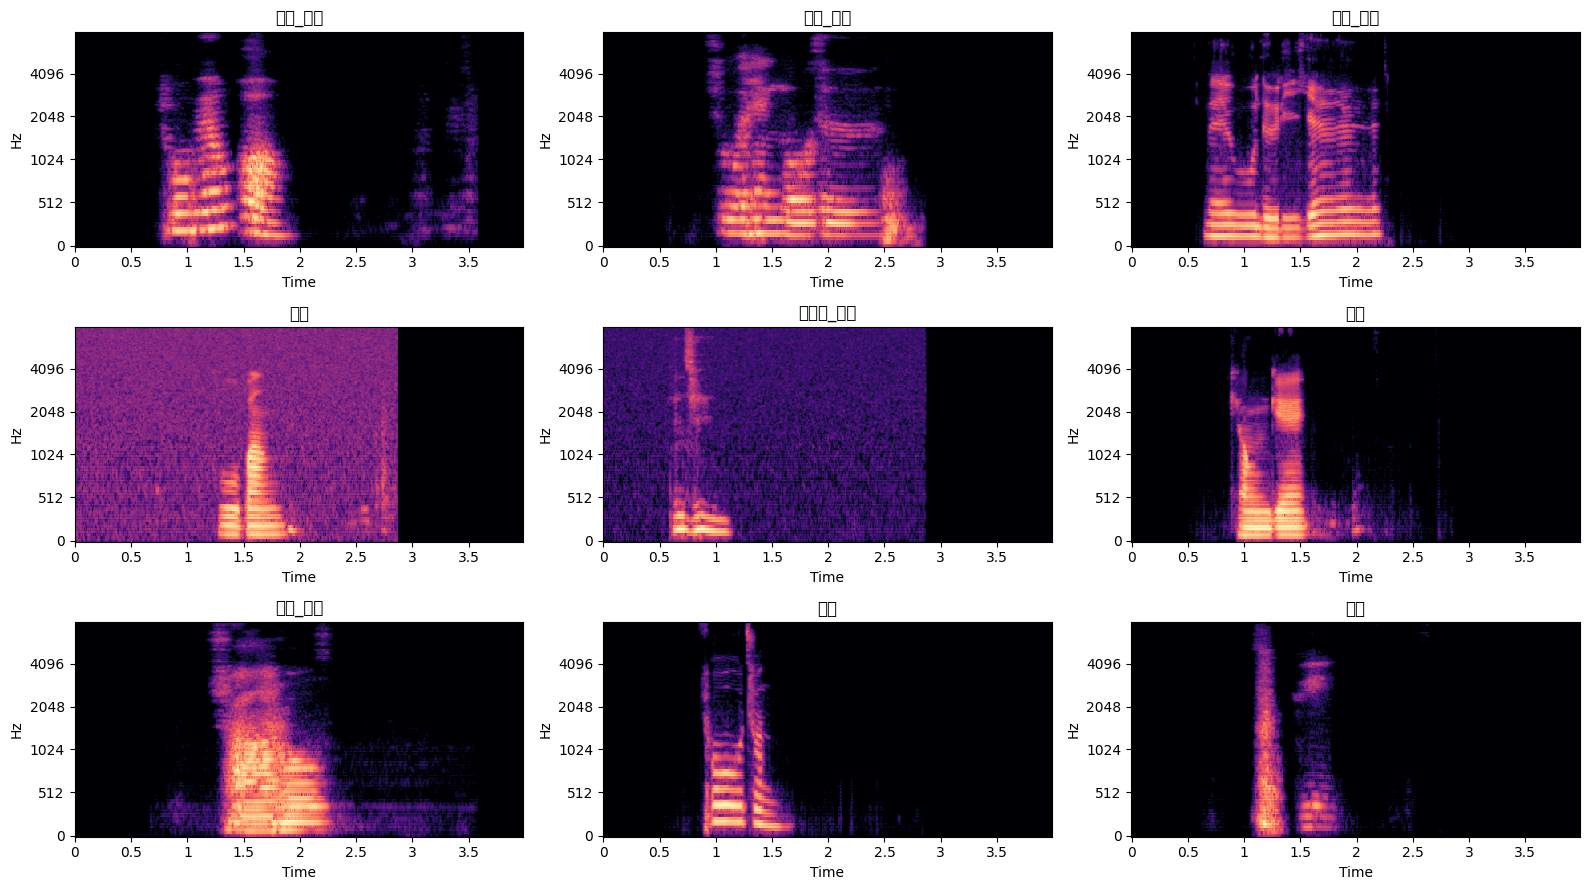

SimpleCNNKWS(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=376320, out_features=128, bias=True)
  (relu3): ReLU()
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
)
Model output shape: torch.Size([32,

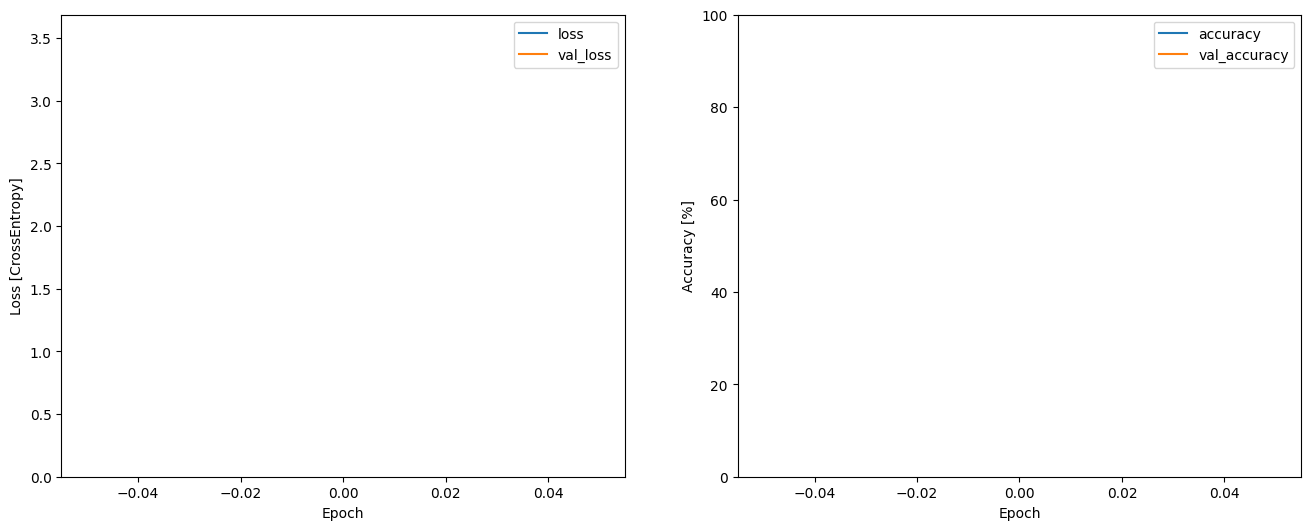

Test Loss: 3.5303, Test Accuracy: 9.58%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44732 (\N{HANGUL SYLLABLE GGEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53020 (\N{HANGUL SYLLABLE KYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

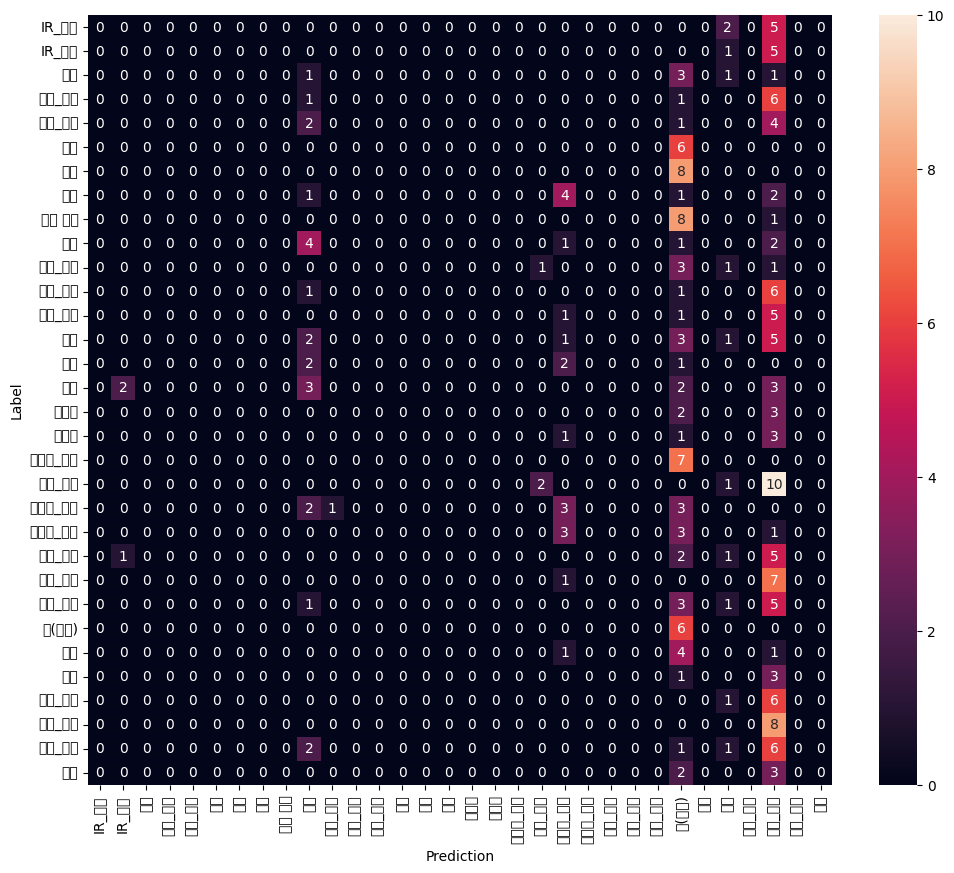


Inference on: /content/korean_speech_commands/only_command/IR_꺼짐/aug_clean_IR_Off_13_stretch.wav
Predicted class ID: 20, Predicted Label: 오른쪽_이동


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51901 (\N{HANGUL SYLLABLE JJOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

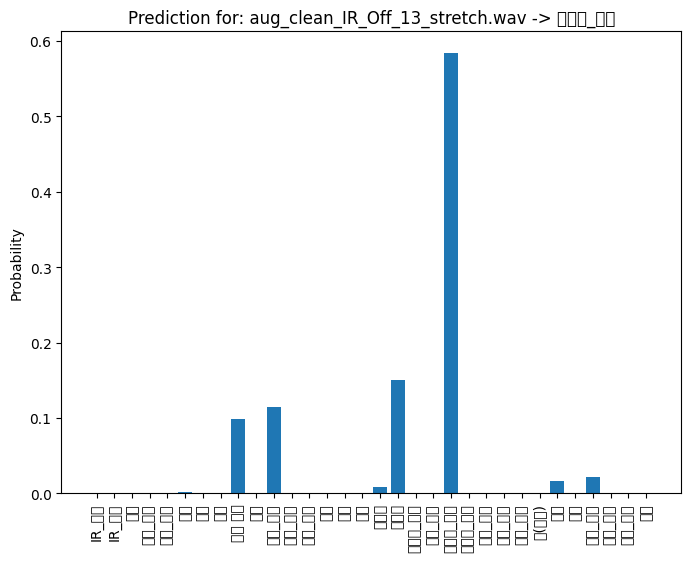

Model successfully exported to ONNX: korean_kws_pytorch.onnx


In [ ]:
# -*- coding: utf-8 -*- GEMINI
"""Korean_Speech_Recognition_PyTorch.ipynb"""

# Install required packages
!pip install -U -q torch torchaudio torchvision # PyTorch and Torchaudio
!pip install -U -q librosa matplotlib seaborn # For feature extraction and plotting
# tf2onnx is not needed for PyTorch to ONNX, torch.onnx is built-in

import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa # For Mel Spectrograms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import torchaudio.transforms as T
from IPython import display

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Configuration ---
# --- Configuration ---
DATASET_PATH = '/content/korean_speech_commands/only_command'  # Replace with your actual path
MAX_AUDIO_SECONDS = 4
SAMPLE_RATE = 16000
TARGET_SEQ_LEN_SAMPLES = MAX_AUDIO_SECONDS * SAMPLE_RATE  # 64000 samples (4 seconds)

# Spectrogram / Feature Parameters (Crucial - match your RKNN model's expected input)
N_MELS = 171        # Number of Mel bands (Height of spectrogram)
TARGET_FRAMES = 560   # Number of time frames (Width of spectrogram)
N_FFT = 512         # FFT window size

# Calculate HOP_LENGTH to get close to TARGET_FRAMES from TARGET_SEQ_LEN_SAMPLES
# Formula: TARGET_FRAMES = floor((num_samples - n_fft) / hop_length) + 1
# So, hop_length approx (num_samples - n_fft) / (TARGET_FRAMES - 1)
# For 4s audio (64000 samples):
# hop_length = (64000 - 512) / (560 - 1) = 63488 / 559 = 113.57...
# Let's use int(113) or int(114). The subsequent resize will handle exact dimensions.
HOP_LENGTH = 114 # This will produce (64000 - 512) / 114 + 1 = 557.8 -> 557 frames from librosa
                 # The torch.nn.functional.interpolate will resize this to TARGET_FRAMES (560).
print(f"Using N_FFT: {N_FFT}, HOP_LENGTH: {HOP_LENGTH}")
num_expected_frames_before_resize = (TARGET_SEQ_LEN_SAMPLES - N_FFT) // HOP_LENGTH + 1
print(f"Number of frames from librosa before resize (approx): {num_expected_frames_before_resize}")


BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 0.001


# --- Data Loading and Preprocessing ---
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    # Attempt to load from Google Drive if in Colab
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        DRIVE_DATASET_PATH = '/content/drive/MyDrive/ble_p/dataset/only_command.zip' # ADJUST
        if pathlib.Path(DRIVE_DATASET_PATH).exists():
            import zipfile
            print(f"Extracting {DRIVE_DATASET_PATH} to {DATASET_PATH}...")
            os.makedirs(pathlib.Path(DATASET_PATH).parent, exist_ok=True)
            with zipfile.ZipFile(DRIVE_DATASET_PATH, 'r') as zip_ref:
                zip_ref.extractall(pathlib.Path(DATASET_PATH).parent) # Extract to parent of 'only_command'
            print("Extraction complete.")
        else:
             raise ValueError(f"Dataset ZIP not found at {DRIVE_DATASET_PATH} and {DATASET_PATH} does not exist.")
    except ModuleNotFoundError: # Not in Colab
        raise ValueError(f"Dataset path {DATASET_PATH} does not exist. Please update DATASET_PATH.")
else:
    print(f"Dataset found at {DATASET_PATH}")


# Get class names (folder names)
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
num_classes = len(class_names)
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for i, name in enumerate(class_names)}

print('Commands (detected folder names):', class_names)
print(f"Found {num_classes} classes.")

# Save labels to a text file
with open('labels_pytorch.txt', 'w', encoding='utf-8') as f:
    f.write("Detected Label Names (PyTorch):\n")
    for i, label in enumerate(class_names):
        f.write(f"{i}: {label}\n")


# Custom PyTorch Dataset
class KoreanSpeechDataset(Dataset):
    def __init__(self, data_path, class_to_idx, sample_rate, target_seq_len_samples,
                 n_mels, target_frames, n_fft, hop_length, transform=None):
        self.data_path = pathlib.Path(data_path)
        self.class_to_idx = class_to_idx
        self.sample_rate = sample_rate
        self.target_seq_len_samples = target_seq_len_samples
        self.n_mels = n_mels
        self.target_frames = target_frames
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.transform = transform # For data augmentation

        self.filepaths = []
        self.labels = []
        for class_name in self.class_to_idx.keys():
            class_dir = self.data_path / class_name
            for filepath in class_dir.glob('*.wav'):
                self.filepaths.append(filepath)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        # Load waveform using torchaudio
        try:
            waveform, sr = torchaudio.load(filepath)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            # Return a dummy tensor and label or skip
            return torch.zeros((1, self.target_seq_len_samples)), torch.tensor(-1)


        # Ensure correct sample rate (resample if necessary)
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)

        # Ensure mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Pad or truncate waveform to target_seq_len_samples
        current_len = waveform.shape[1]
        if current_len < self.target_seq_len_samples:
            padding = self.target_seq_len_samples - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        elif current_len > self.target_seq_len_samples:
            waveform = waveform[:, :self.target_seq_len_samples]

        # Apply data augmentation if a transform is provided
        if self.transform:
            waveform = self.transform(waveform)

        # Get Mel Spectrogram using librosa (as it's often more flexible for params)
        # Convert to numpy for librosa
        waveform_np = waveform.squeeze().numpy()
        # Calculate POWER spectrogram first
        mel_spec_power = librosa.feature.melspectrogram(y=waveform_np, sr=self.sample_rate,
                                                  n_fft=self.n_fft, hop_length=self.hop_length,
                                                  n_mels=self.n_mels, power=2.0) # power=2.0 for power spec
        # Convert power spectrogram to dB scale
        log_mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max) # Shape: (n_mels, num_frames)

        # Convert to tensor, add channel dimension (which specshow will squeeze out)
        log_mel_spec_tensor = torch.from_numpy(log_mel_spec_db).float().unsqueeze(0) # [1, n_mels, num_frames]

        # Resize to target width (TARGET_FRAMES)
        if log_mel_spec_tensor.shape[2] != self.target_frames: # If number of frames is not already TARGET_FRAMES
            # Interpolate expects [Batch, Channel, Height, Width] or [C, H, W]
            # Our log_mel_spec_tensor is effectively [C=1, H=n_mels, W=actual_frames]
            # We add a dummy batch for interpolate, then squeeze it out
            resized_spec = torch.nn.functional.interpolate(
                log_mel_spec_tensor.unsqueeze(0), # [1, 1, n_mels, actual_frames]
                size=(self.n_mels, self.target_frames), # Target H (n_mels), W (target_frames)
                mode='bilinear',
                align_corners=False
            ).squeeze(0) # Back to [1, n_mels, target_frames]
        else:
            resized_spec = log_mel_spec_tensor

        return resized_spec, torch.tensor(label)


# Create dataset instance
full_dataset = KoreanSpeechDataset(data_dir, class_to_idx, SAMPLE_RATE, TARGET_SEQ_LEN_SAMPLES,
                                   N_MELS, TARGET_FRAMES, N_FFT, HOP_LENGTH)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Verify a batch
for specs, labels in train_loader:
    print("Batch spectrogram shape:", specs.shape) # Should be [BATCH_SIZE, 1, N_MELS, TARGET_FRAMES]
    print("Batch labels shape:", labels.shape)
    example_spectrograms = specs
    example_spect_labels = labels
    break


# Plot spectrogram (function adapted for PyTorch tensors)
def plot_spectrogram_pytorch(spectrogram_tensor, ax, title="Spectrogram"):
    # Assuming spectrogram_tensor from your DataLoader is already the log_mel_spec_db
    # (output of librosa.power_to_db) and has shape [1, N_MELS, TARGET_FRAMES]

    spectrogram_to_plot = spectrogram_tensor.squeeze().cpu().numpy()
    # Now spectrogram_to_plot has shape (N_MELS, TARGET_FRAMES), e.g., (171, 560)
    # This is already log-scaled (dB) if your dataset prepares it that way.

    # librosa.display.specshow handles axes correctly for (freq_bins, time_frames) input
    img = librosa.display.specshow(spectrogram_to_plot,
                                   sr=SAMPLE_RATE,      # Defined in your notebook
                                   hop_length=HOP_LENGTH, # Defined in your notebook
                                   x_axis='time',
                                   y_axis='mel',        # Assumes it's a Mel spectrogram
                                   ax=ax,
                                   cmap='magma')       # You can choose other cmaps like 'viridis'
    ax.set_title(title)



# Visualize some spectrograms from a batch
if 'example_spectrograms' in locals():
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
    for i in range(min(n, example_spectrograms.size(0))): # Handle cases where batch is smaller than n
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        plot_spectrogram_pytorch(example_spectrograms[i], ax, title=idx_to_class[example_spect_labels[i].item()])
    plt.tight_layout()
    plt.show()
else:
    print("No spectrogram examples to plot. Check data loading.")


# --- Model Definition ---
class SimpleCNNKWS(nn.Module):
    def __init__(self, input_height, input_width, num_classes):
        super(SimpleCNNKWS, self).__init__()
        # Input shape: [Batch, Channels=1, Height=N_MELS, Width=TARGET_FRAMES]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32) # Batch norm after conv, before relu or after relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Calculate the flattened size after convolutions and pooling
        # After conv1+pool1: H_out = H_in/2, W_out = W_in/2
        # After conv2+pool2: H_out = H_in/4, W_out = W_in/4
        # Example: Input (171, 560) -> Pool1 -> (85, 280) -> Pool2 -> (42, 140) (approx due to int division)
        # Let's calculate it dynamically or ensure it's correct
        # For input H=171, W=560:
        # Conv1 (same padding) -> (171, 560)
        # Pool1 (kernel=2, stride=2) -> (171//2, 560//2) = (85, 280)
        # Conv2 (same padding) -> (85, 280)
        # Pool2 (kernel=2, stride=2) -> (85//2, 280//2) = (42, 140)
        # So, flattened_size = 64 * 42 * 140
        self.flattened_size = 64 * (input_height // 4) * (input_width // 4)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(128) # BatchNorm1d for dense layer input
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: [batch, 1, N_MELS, TARGET_FRAMES]
        x = self.pool1(self.bn1(self.relu1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(self.bn2(self.relu2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dropout3(self.bn3(self.relu3(self.fc1(x))))
        x = self.fc2(x) # Output logits
        return x

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNKWS(input_height=N_MELS, input_width=TARGET_FRAMES, num_classes=num_classes).to(device)
print(model)

# Test with a dummy input
dummy_input_for_model_test = torch.randn(BATCH_SIZE, 1, N_MELS, TARGET_FRAMES).to(device)
output_test = model(dummy_input_for_model_test)
print("Model output shape:", output_test.shape) # Should be [BATCH_SIZE, num_classes]


# --- Training Loop ---
criterion = nn.CrossEntropyLoss() # Softmax is included in CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0: # Print every 10 mini-batches
             print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc / 100.0) # Store as fraction for consistency with Keras history
    print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc / 100.0)
    print(f"Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_korean_kws_pytorch_model.pth') # Save best model
        print(f"Validation loss improved. Saved best model to best_korean_kws_pytorch_model.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_korean_kws_pytorch_model.pth'))


# --- Plot training results ---
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history['loss'])), history['loss'], label='loss')
plt.plot(range(len(history['val_loss'])), history['val_loss'], label='val_loss')
plt.legend()
plt.ylim([0, max(plt.ylim()) if plt.ylim()[1] > 0 else 1]) # Adjust y-lim
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(range(len(history['accuracy'])), [acc * 100 for acc in history['accuracy']], label='accuracy')
plt.plot(range(len(history['val_accuracy'])), [acc * 100 for acc in history['val_accuracy']], label='val_accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()


# --- Evaluate on Test Set ---
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# --- Confusion Matrix ---
if total_test > 0 : # Only plot if test set is not empty
    confusion_mtx = tf.math.confusion_matrix(all_true, all_preds) # Using tf for consistency with original notebook
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_mtx,
                xticklabels=class_names, # Use PyTorch derived class_names
                yticklabels=class_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
else:
    print("Test dataset is empty, skipping confusion matrix.")


# --- Inference on a Sample File ---
# Create a function for inference like in the TF notebook
def infer_pytorch_model(model_to_infer, audio_filepath_str, class_idx_to_name_map):
    model_to_infer.eval() # Ensure model is in eval mode
    # Load and preprocess the single audio file
    waveform, sr = torchaudio.load(audio_filepath_str)
    if sr != SAMPLE_RATE:
        resampler = T.Resample(sr, SAMPLE_RATE)
        waveform = resampler(waveform)
    if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)

    current_len = waveform.shape[1]
    if current_len < TARGET_SEQ_LEN_SAMPLES:
        padding = TARGET_SEQ_LEN_SAMPLES - current_len
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    elif current_len > TARGET_SEQ_LEN_SAMPLES:
        waveform = waveform[:, :TARGET_SEQ_LEN_SAMPLES]

    waveform_np = waveform.squeeze().numpy()
    mel_spec = librosa.feature.melspectrogram(y=waveform_np, sr=SAMPLE_RATE,
                                              n_fft=N_FFT, hop_length=HOP_LENGTH,
                                              n_mels=N_MELS)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec_tensor = torch.from_numpy(log_mel_spec).float().unsqueeze(0) # [1, N_MELS, actual_frames]

    if log_mel_spec_tensor.shape[2] != TARGET_FRAMES:
        resized_spec = torch.nn.functional.interpolate(
            log_mel_spec_tensor.unsqueeze(0), # Add batch: [1, 1, N_MELS, actual_frames]
            size=(N_MELS, TARGET_FRAMES),     # Target H, W
            mode='bilinear',
            align_corners=False
        ).squeeze(0) # Remove batch: [1, N_MELS, TARGET_FRAMES]
    else:
        resized_spec = log_mel_spec_tensor

    input_tensor = resized_spec.unsqueeze(0).to(device) # Add batch dim back: [1, 1, N_MELS, TARGET_FRAMES]

    with torch.no_grad():
        logits = model_to_infer(input_tensor)
        probabilities = torch.softmax(logits, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        predicted_label = class_idx_to_name_map[predicted_idx]

    print(f"\nInference on: {audio_filepath_str}")
    print(f"Predicted class ID: {predicted_idx}, Predicted Label: {predicted_label}")

    plt.figure(figsize=(8,6))
    plt.bar(class_idx_to_name_map.values(), probabilities.squeeze().cpu().numpy())
    plt.title(f'Prediction for: {os.path.basename(audio_filepath_str)} -> {predicted_label}')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.show()

    # Display audio for verification
    display.display(display.Audio(waveform_np, rate=SAMPLE_RATE)) # Display original (padded/trimmed) waveform

# Example usage of inference function
# Make sure this file exists in your dataset structure
sample_path_str = str(data_dir / class_names[0] / os.listdir(data_dir / class_names[0])[0]) # Takes the first file from the first class
if os.path.exists(sample_path_str):
    infer_pytorch_model(model, sample_path_str, idx_to_class)
else:
    print(f"Sample audio file for inference not found at: {sample_path_str}")


# --- Export to ONNX ---
# Load the best model weights
model.load_state_dict(torch.load('best_korean_kws_pytorch_model.pth'))
model.eval() # IMPORTANT: Set to evaluation mode before export

# Create a dummy input with the correct shape [Batch, Channels, Height, Width]
# This MUST match the input shape your model expects.
# For our SimpleCNNKWS, input is [Batch, 1, N_MELS, TARGET_FRAMES]
dummy_input = torch.randn(1, 1, N_MELS, TARGET_FRAMES).to(device)
onnx_model_path = "korean_kws_pytorch.onnx"

try:
    torch.onnx.export(model,                        # model being run
                      dummy_input,                  # model input (or a tuple for multiple inputs)
                      onnx_model_path,              # where to save the model
                      export_params=True,           # store the trained parameter weights inside the model file
                      opset_version=13,             # the ONNX version to export the model to
                      do_constant_folding=True,     # whether to execute constant folding for optimization
                      input_names = ['input_spectrogram'], # model's input names
                      output_names = ['output_logits'],   # model's output names
                      dynamic_axes={'input_spectrogram' : {0 : 'batch_size'}, # variable length axes
                                    'output_logits' : {0 : 'batch_size'}})
    print(f"Model successfully exported to ONNX: {onnx_model_path}")
except Exception as e:
    print(f"Error during ONNX export: {e}")

In [ ]:
model.export(format="rknn", name="rk3588")